In [2]:
import numpy as np
from numpy.linalg import qr
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import random
import os

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend

In [3]:
def innit_fourpanel_subplots():
    
    fig, axs = plt.subplot_mosaic([['A)', 'B)'], ['C)', 'D)']],figsize=(14,10.5), constrained_layout=True)

    for label, ax in axs.items():
        # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
                fontsize='xx-large', va='bottom')
        
    axs = [i for i in axs.values()]
    fig = fig.set_dpi(400)
        
    return fig, axs

In [4]:
def back_sub(U, y):
    
    n = U.shape[0]
    x = np.zeros(n)
    
    for i in range(n-1, -1, -1):
        s = 0 
        for j in range(i+1, n):
            s += U[i][j] * x[j]
        x[i]= (y[i] - s) / U[i][i]
        
    return x

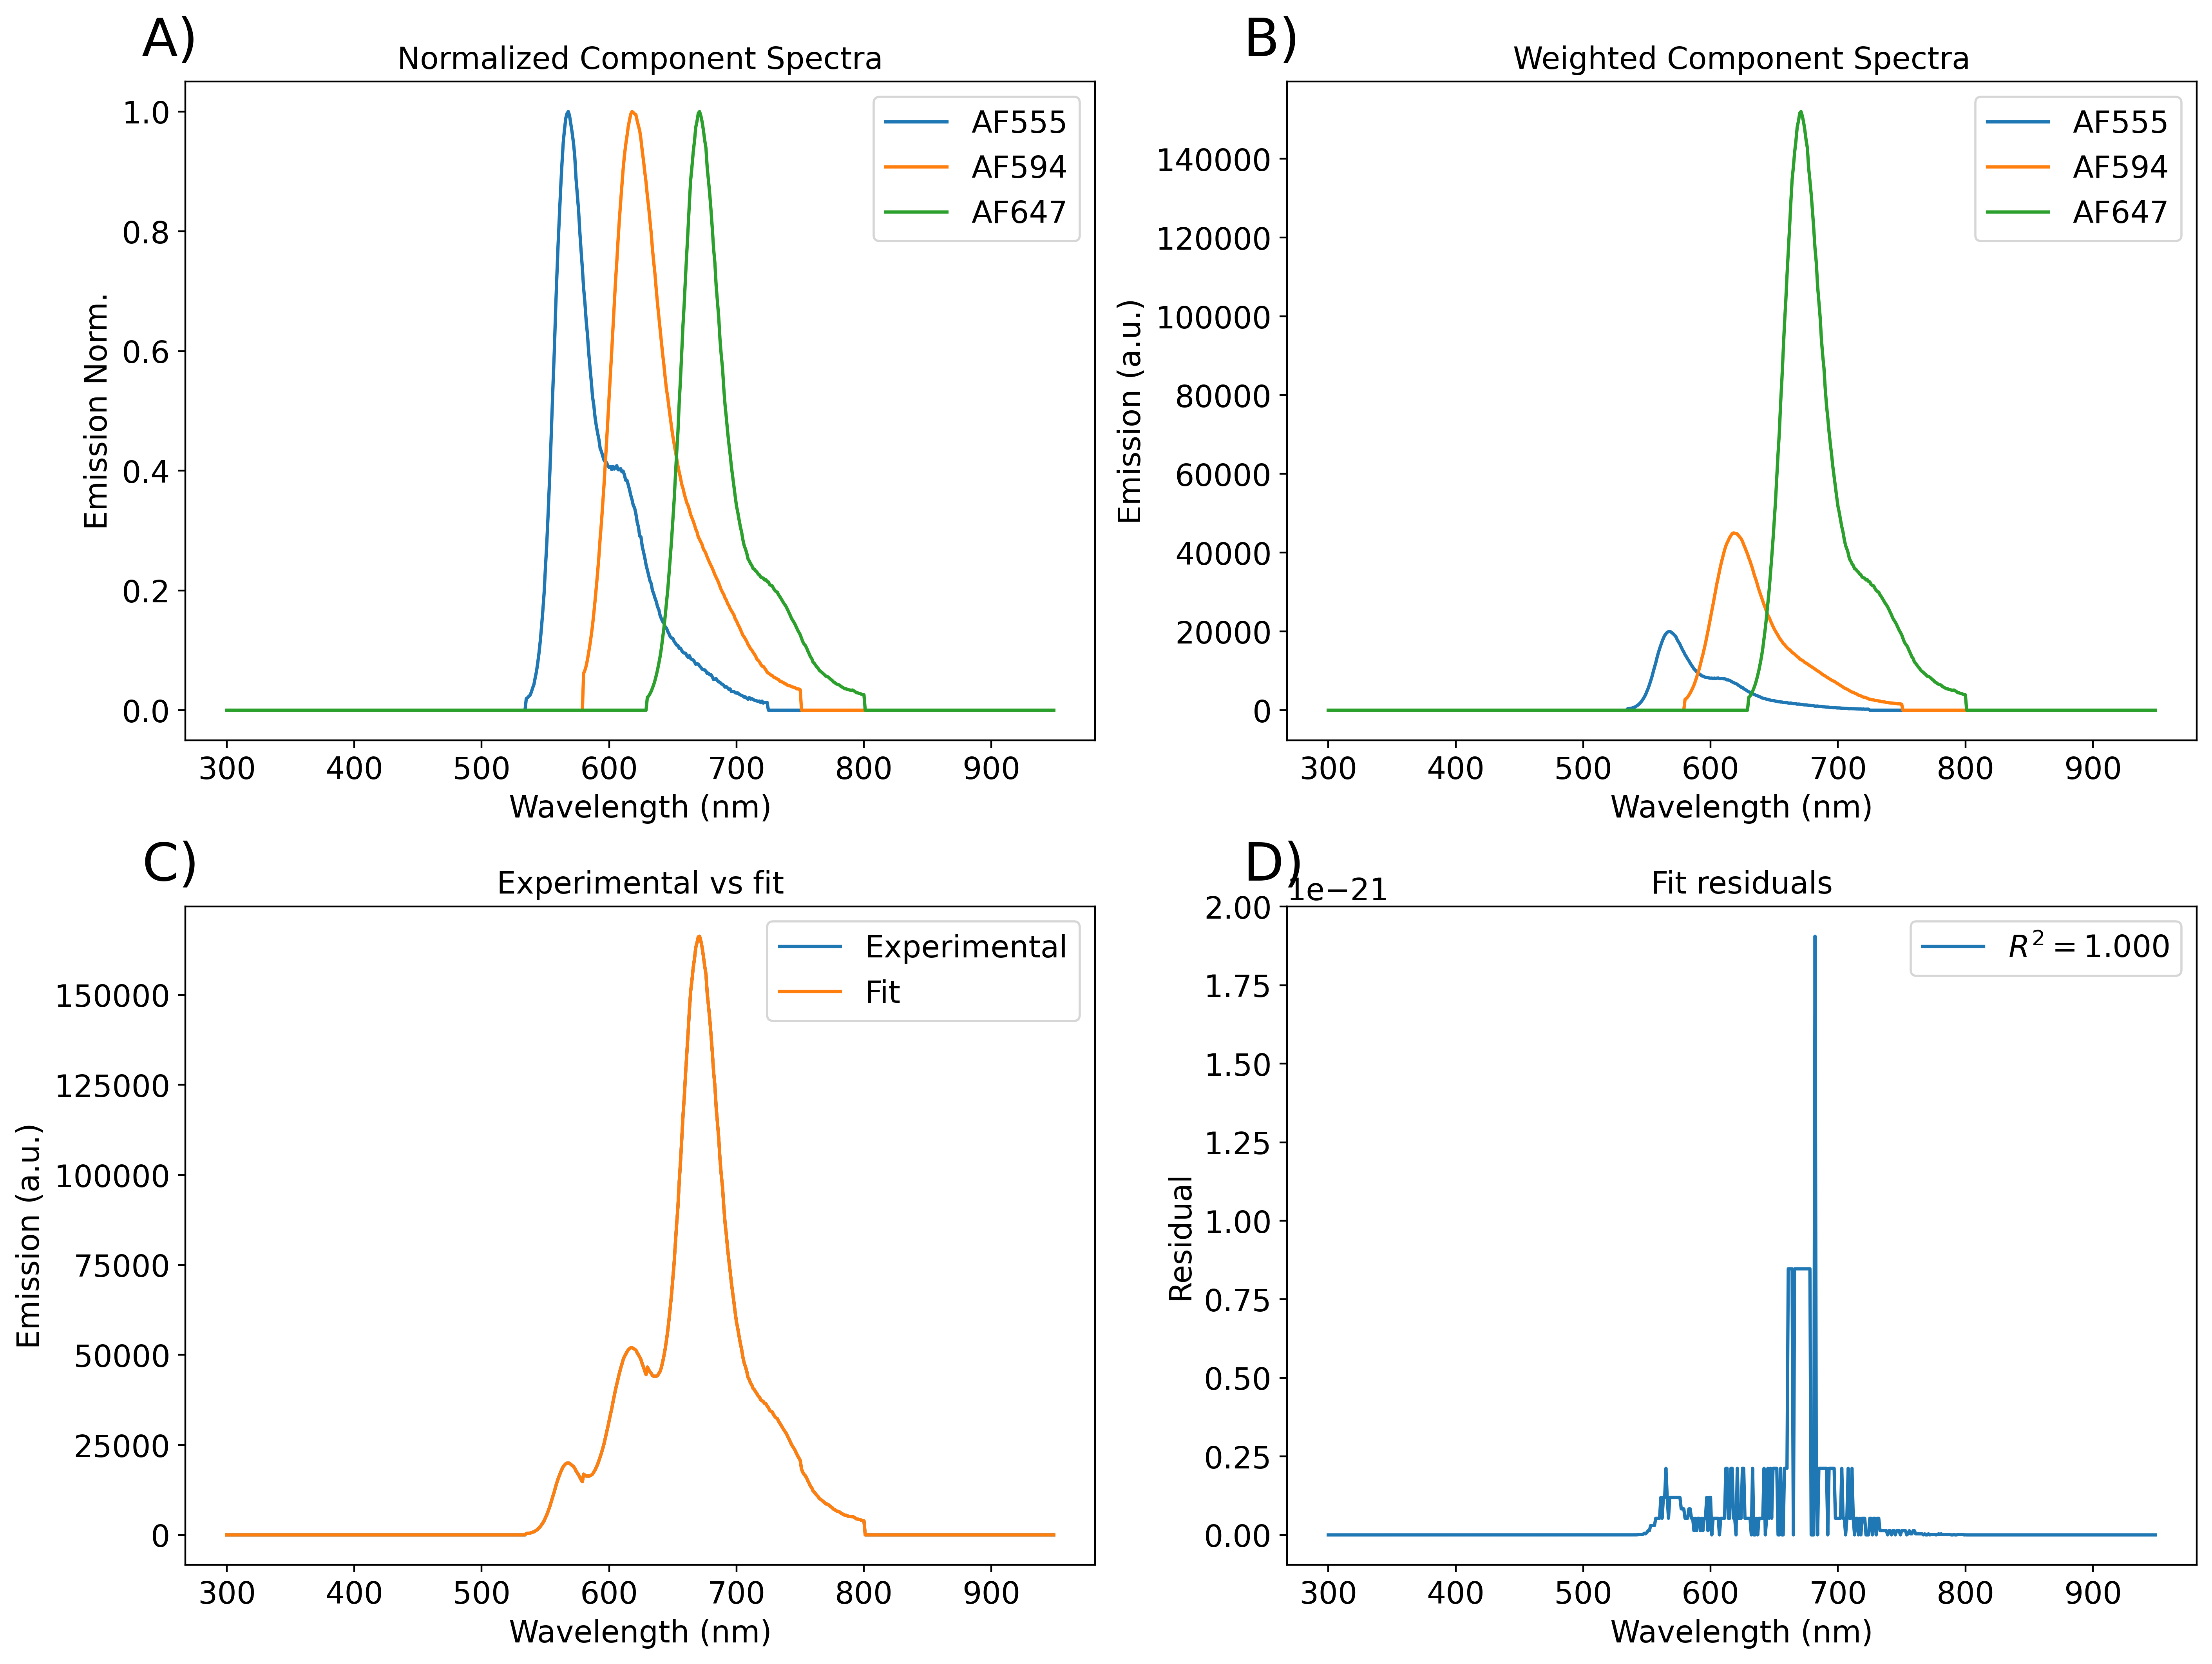

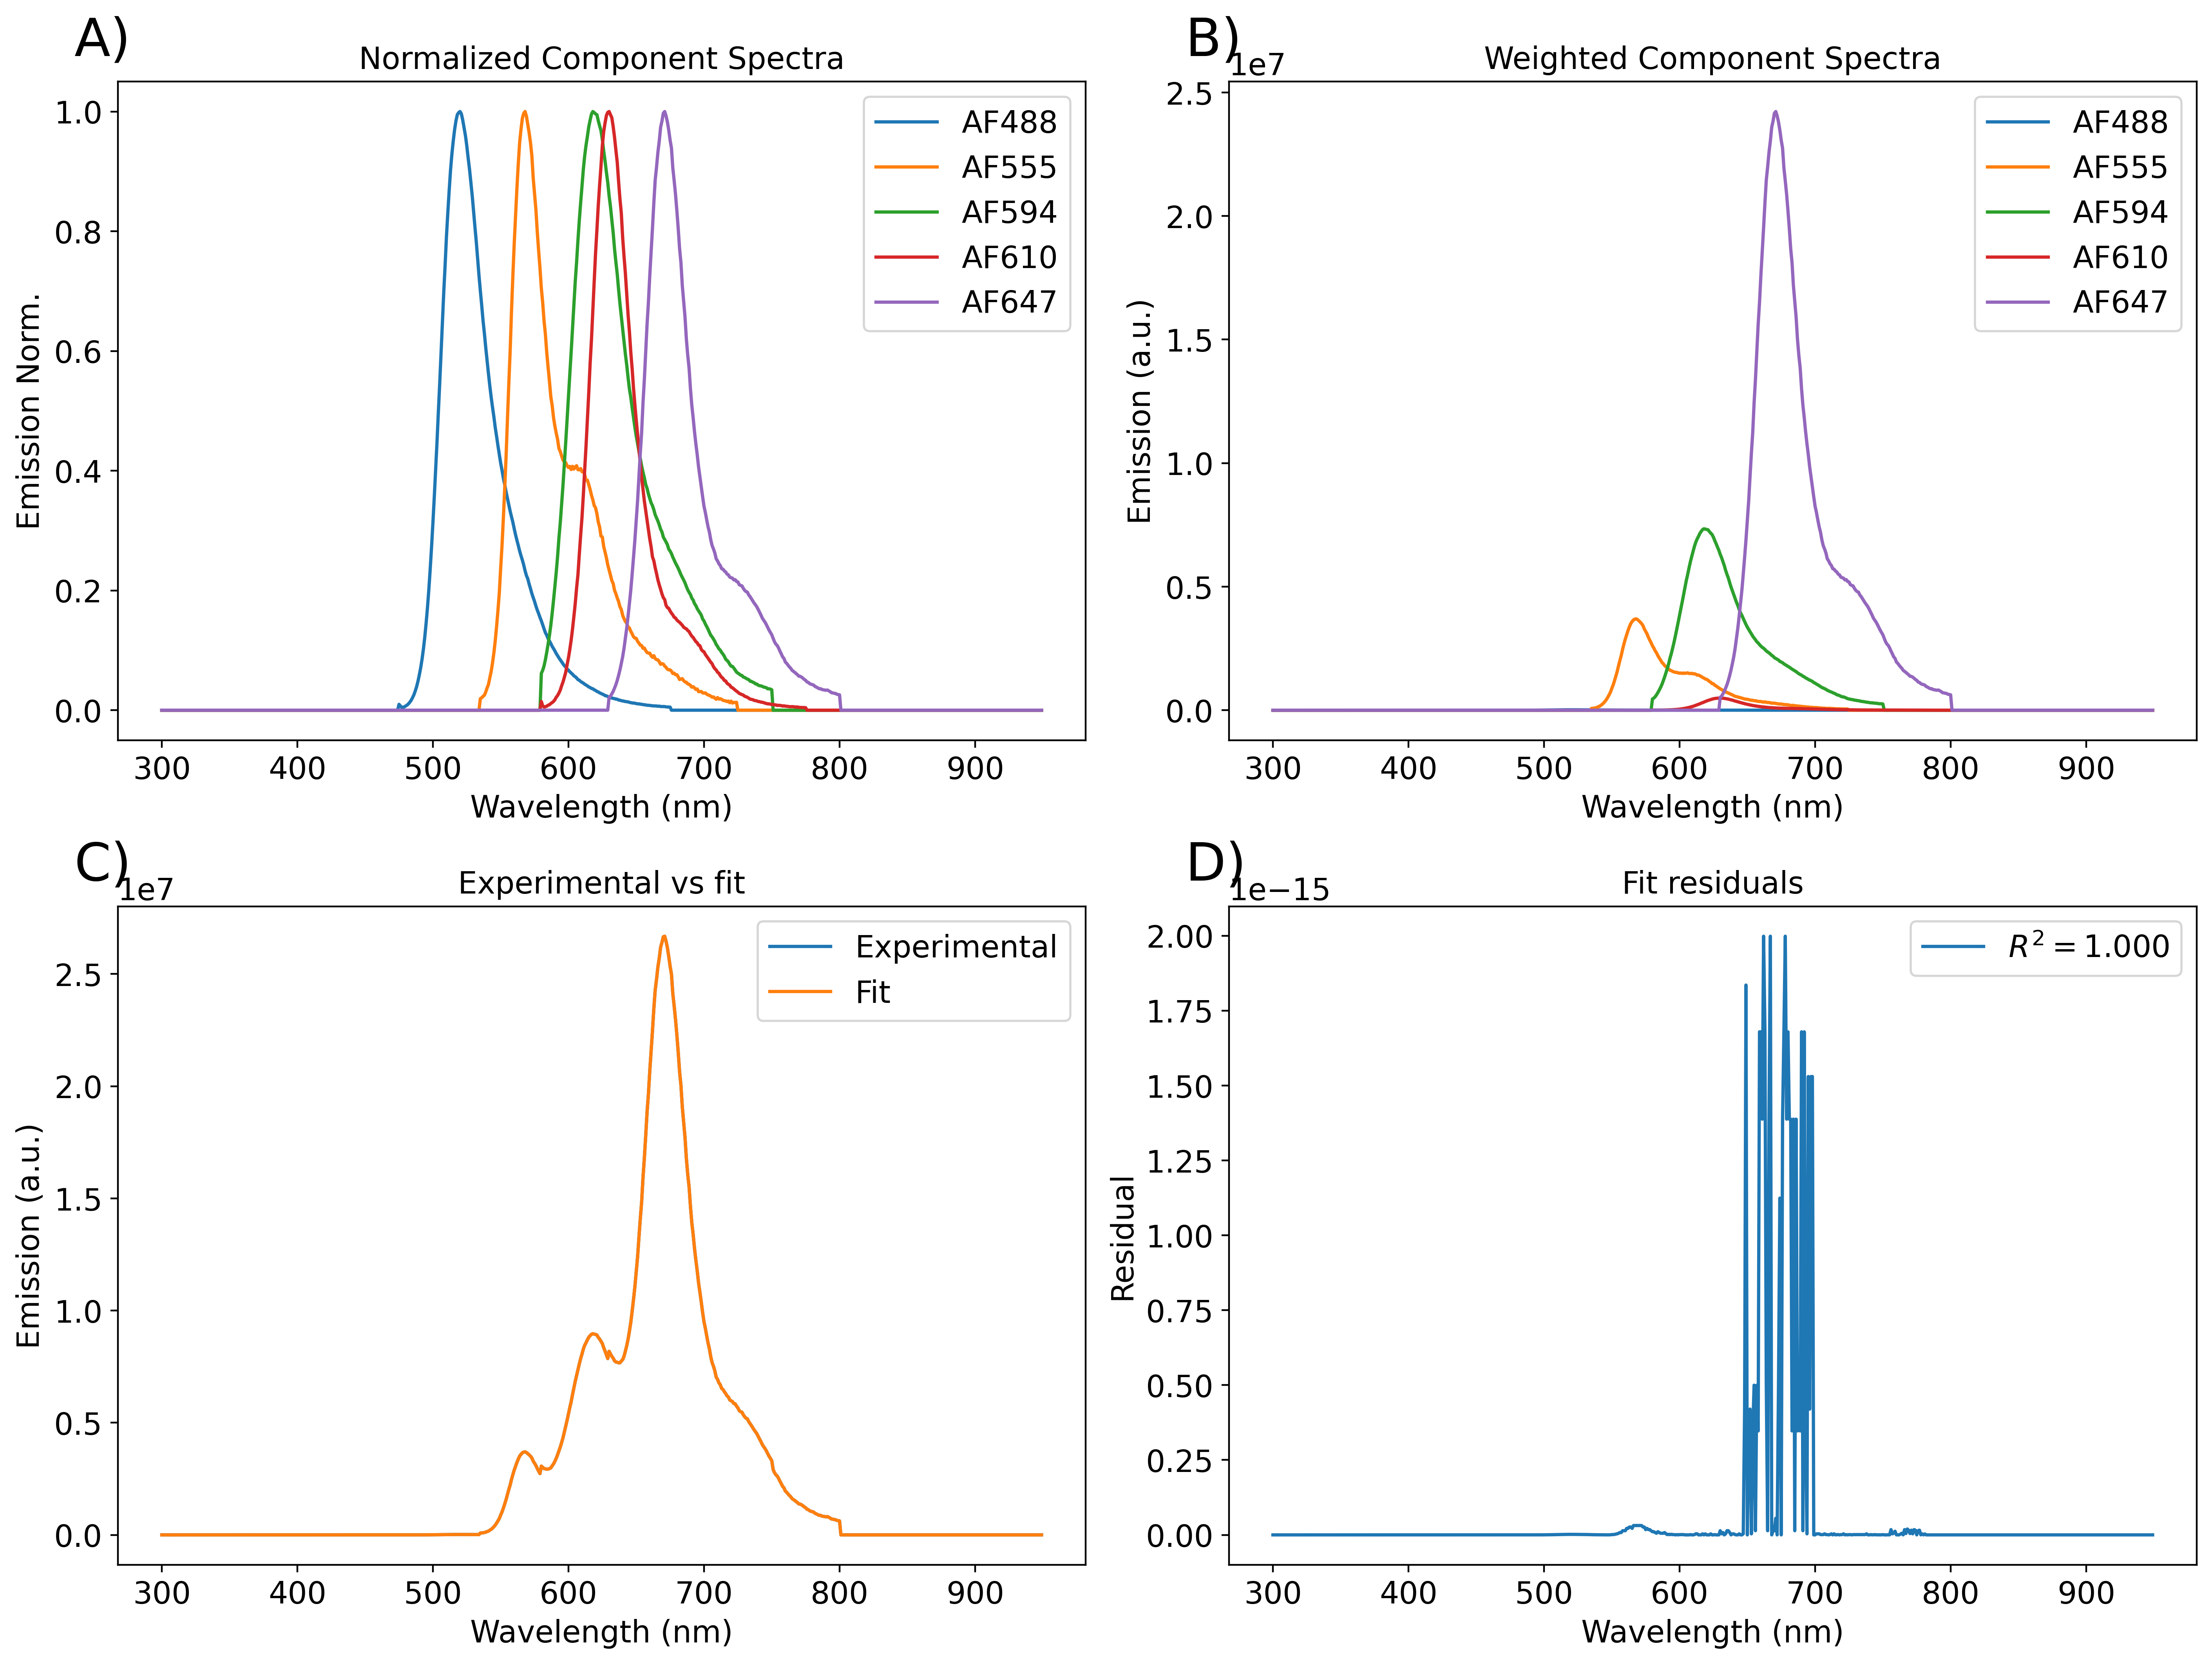

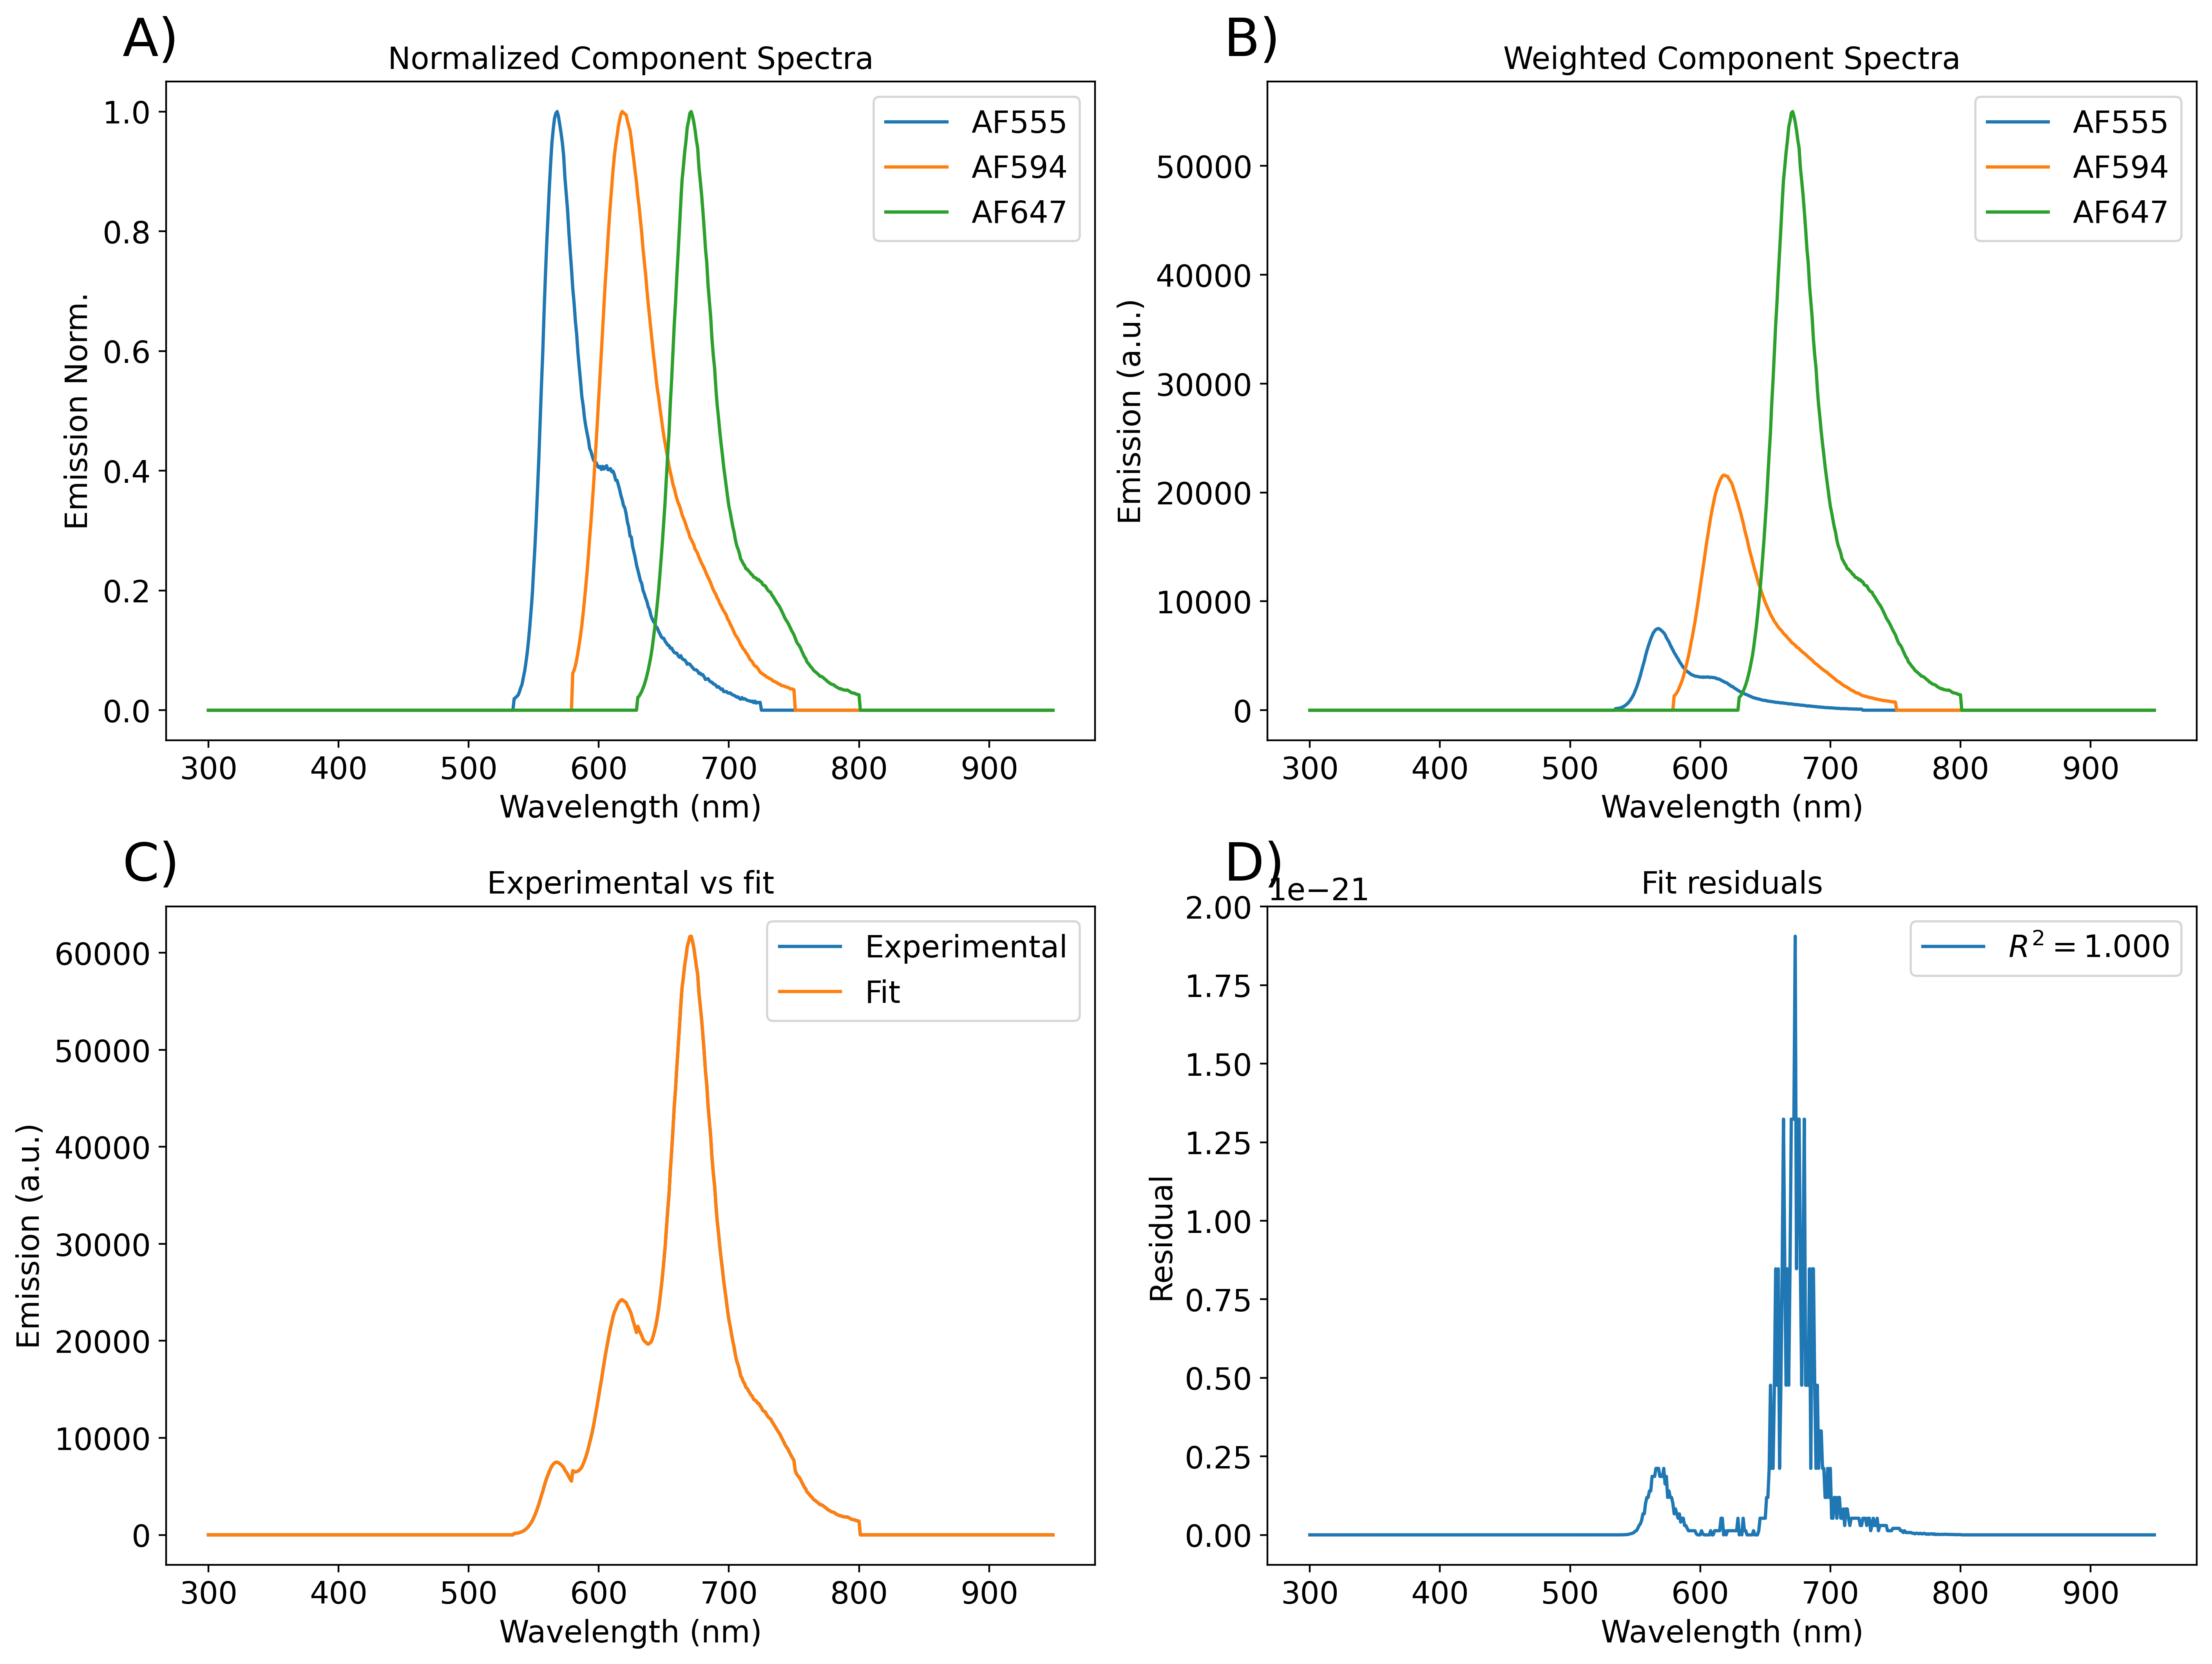

In [7]:
# we start by creating a dictionary which stores our components and allows for easy access
def create_component_dict():
    ### creates a dictionary which stores each of the components by key ###
    component_dict = {}
        
    for idx, file in enumerate(os.listdir('components')):
        
        if file == '.ipynb_checkpoints': # ignore jupyter files
            pass
        else:
            # strips the .csv extension and stores the spectra in a array 
            component_dict[file.strip('.csv')] = pd.read_csv(f'components/{file}', index_col=0).values
            
    # while we are reading in files it would be useful to get the actual wavelength values as well    
    wl =  pd.read_csv(f'components/{file}', index_col=0).index.values
    
    return component_dict, wl

# the component dictionary is created and now we can start reading the experimental spectra
component_dict, wl = create_component_dict()

# the variable B stores the full set of experimental spectra to be fit.
# then each sample can be iterated through. 
B = pd.read_csv('experimental/experimental_spectra.csv', index_col=0)

# as we iterate we want to be able to identify the present components from the sample label
def find_present_components(b):
    present_components = [] # stores list of dyes in the sample
    
    comps = b.split('+') # splits the sample name into the dye and concentration
    comps = [c.strip(' ') for c in comps] # strips possible spacing
    
    for c in comps:
        dye = c.split(' ')[1] # selects the specific dye name
        present_components.append(dye) # adds the dye component to the list 
        
    return present_components

# next we need to create our A matrix using the component_dict and components in the sample
def create_component_matrix(component_dict, present_components):
    
    ### first we need to initialize an empty matrix with the proper shape (ie. m x n)
    # for clarity "m" refers to the the rows which is the sampled wavelength range
    #    and "n" refers to the number of dye components
    
    # each component needs to be formatted the same to get the correct m
    n = len(present_components)
    m = component_dict[present_components[0]].shape[0]
    
    A = np.empty((m,n))
    
    ### next we iterate through the present components and add each spectra as column vectors
    for i, component in enumerate(present_components):
        
        # reshape is to make dimensions compatible... idk why its needed though
        A[:, i] = (component_dict[component]).reshape(m)
        
    return A

# now we need a way to estimate the weights of each component
# to do this we factor the matrix A into two matrices Q and R where Q is orthogonal and R is upper triangular
# once we have Q and R we can use back substitution to solve for the optimal component weights
# back_sub method is defined above
# i think its most numerically stable method, more info below :
# https://math.stackexchange.com/questions/3185211/what-does-qr-decomposition-have-to-do-with-least-squares-method
def estimate_weights(A, b):
    
    Q, R = qr(A)
    y = np.dot(Q.T, b)
    
    x = back_sub(R, y)
    
    return x

# we dont really need the weights though, we need the weighted components
# so we iterate through the weights and scale the components
def scale_components(A, x):
    
    # initialize new array for weighted components
    weighted_A = np.empty(A.shape)
    
    for idx, x in enumerate(x):
        
        # weigh the components
        weighted_A[:,idx] = A[:,idx] * x
    
    return weighted_A
    
# finally we will be interested in calculating the residuals to estimate goodness of fit
def measure_residuals(weighted_A, b):
    
    # sum the weighted components to get fit
    fit = weighted_A.sum(axis=1)
    
    residuals = (b - fit) ** 2
    
    return residuals

# we will want to visualize the fits with plots
def plot_fit_data(present_components, A, b_vector, weighted_A, residuals, sample_name):
    
    fig, ax = innit_fourpanel_subplots()
    
    # top left - normalized components
    ax[0].plot(wl,A/A.max(axis=0))
    ax[0].legend(present_components)
    ax[0].set_xlabel('Wavelength (nm)')
    ax[0].set_ylabel('Emission Norm.')
    ax[0].set_title('Normalized Component Spectra')
    
    # top right - weighted components
    ax[1].plot(wl,weighted_A)
    ax[1].legend(present_components)
    ax[1].set_xlabel('Wavelength (nm)')
    ax[1].set_ylabel('Emission (a.u.)')
    ax[1].set_title('Weighted Component Spectra')
    
    # bottom left - experimental vs fit spectra 
    ax[2].plot(wl, b_vector)
    ax[2].plot(wl, weighted_A.sum(axis=1))
    ax[2].legend(['Experimental', 'Fit'])
    ax[2].set_xlabel('Wavelength (nm)')
    ax[2].set_ylabel('Emission (a.u.)')
    ax[2].set_title('Experimental vs fit')
    
    # bottom right - residuals
    R2 = 1 - (residuals.sum() / ((b_vector - b_vector.mean())**2).sum())
    ax[3].plot(wl,residuals)
    ax[3].legend([f'$R^{2}={R2:0.3f}$'])
    ax[3].set_xlabel('Wavelength (nm)')
    ax[3].set_ylabel('Residual')
    ax[3].set_title('Fit residuals')
    
    plt.savefig(f'plots/{sample_name}.png')
    plt.savefig(f'plots/{sample_name}.svg')
    plt.show()

# in addition to 
def export_fit(wl, present_components, b_vector, weighted_A, residuals):
    
    # for adding each of the component spectra and integrated spectra 
    spectra = {}
    spectra_area = {}
    
    for idx, component in enumerate(present_components):
        spectra[f'Fit {component}'] = weighted_A[:,idx]
        spectra_area[f'Fit {component} integrated'] = weighted_A[:,idx].sum()
    
    
    data = pd.DataFrame(spectra, index=wl) # initialize df with the weighed component spectra
    data.index.name = "Wavelength (nm)" # just change the index header to wavelengths
    data['Fit full'] = weighted_A.sum(axis=1) # adds the fit
    data['Experimental'] = b_vector # adds the original experimental spectra
    data['Residuals'] = residuals # adds the residuals at each wavelength
    
    # because adding dictionaries is annoying af just do this little loop to add the integrated spectra
    for key in spectra_area.keys():
        data.loc[wl[0],key] = spectra_area[key] 
        
    data.loc[wl[0], 'Fit full Integrated'] = weighted_A.sum(axis=1).sum() # integrate the fit and add that
    data.loc[wl[0], 'Sum residuals'] = residuals.sum() # sum of the resiudals i.e. (b - fit)**2.sum()
    data.loc[wl[0], 'Coeff of Determination (R2)'] = 1 - (residuals.sum() / ((b_vector - b_vector.mean())**2).sum()) # R squared value for goodness of fit
    
    return data

component_dict, wl = create_component_dict()     

# now we can iterate through B and pull out each spectra b and the corresponding component matrix A
for b in B.columns:
    
    present_components = find_present_components(b) # pull out which components are present
    A = create_component_matrix(component_dict, present_components) # create the component matrix
    b_vector = B[b].values # define experimental spectra 
    b_vector[b_vector < 0] = 0 ### optional - constrain the experimental spectra to > 0 ###
    x = estimate_weights(A, b_vector) # estimate weights 
    weighted_A = scale_components(A, x) # scale the component vectors
    residuals = measure_residuals(weighted_A, b_vector) # caluculate residuals
    plot_fit_data(present_components, A, b_vector, weighted_A, residuals, b) # plot data
    data = export_fit(wl, present_components, b_vector, weighted_A, residuals)
    data.to_csv(f'exported data/{b} fit data.csv')
    